In [1]:
from examples.util.getDataset import getDataset
from examples.util.plotting import plot_w
from examples.util.test_fns import *
from sparse_rf.util import *
from sparse_rf.modules import make_A, make_W
from sparse_rf.algs import shrimp, l2, l1, sindy
from functools import partial
import matplotlib.pyplot as plt
from math import ceil

In [2]:
fn = fn4
q = 2
d = 10
m = 200
N = 1000

In [19]:
Xtr, Xte, Ytr, Yte = getDataset(fn, d=d, m=m)
best_model, train_mses, val_mses, lengths = shrimp(Xtr, Ytr, orderCands=[q], verbose=0, N=N)
w_shrimp = np.zeros(2*best_model.W.shape[0])
w_shrimp[best_model.id_list] = best_model.w
Atr = make_A(Xtr, best_model.W)
w_l2 = l2(Atr, Ytr)
Ate = make_A(Xte, best_model.W)
err_shrimp = np.sum((Yte-Ate@w_shrimp)**2)/len(Yte)
err_l2 = np.sum((Yte-Ate@w_l2)**2)/len(Yte)

In [20]:
best_model_r, train_mses_r, val_mses_r, _ = shrimp(Xtr, Ytr, orderCands=[q], verbose=0, N=N, random=True)
w_r = np.zeros(2*best_model_r.W.shape[0])
w_r[best_model_r.id_list] = best_model_r.w
Ate = make_A(Xte, best_model_r.W)
err_r = np.sum((Yte-Ate@w_r)**2)/len(Yte)

In [21]:
print("Min l2: {}".format(err_l2))
print("SHRIMP: {}".format(err_shrimp))
print("Random pruning: {}".format(err_r))

Min l2: 0.22511009970131143
SHRIMP: 1.7273266488144532e-07
Random pruning: 0.24807545712340495


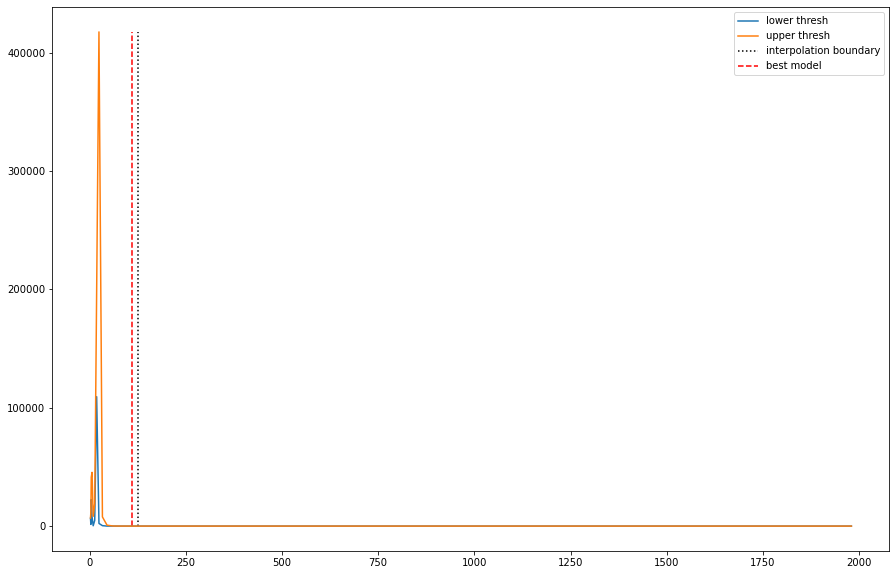

In [22]:
thresh = list(zip(*list(best_model.thresh.values())))
plt.figure(figsize=(15, 10))
plt.plot(lengths[:-1], thresh[0], label="lower thresh")
plt.plot(lengths[:-1], thresh[1], label="upper thresh")
plt.vlines(m*0.7*0.9, 0, max(max(thresh[0]), max(thresh[1])), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(best_model.n_best, 0, max(max(thresh[0]), max(thresh[1])), linestyles="dashed", colors="red", label="best model")
plt.legend(loc="best")
plt.show()

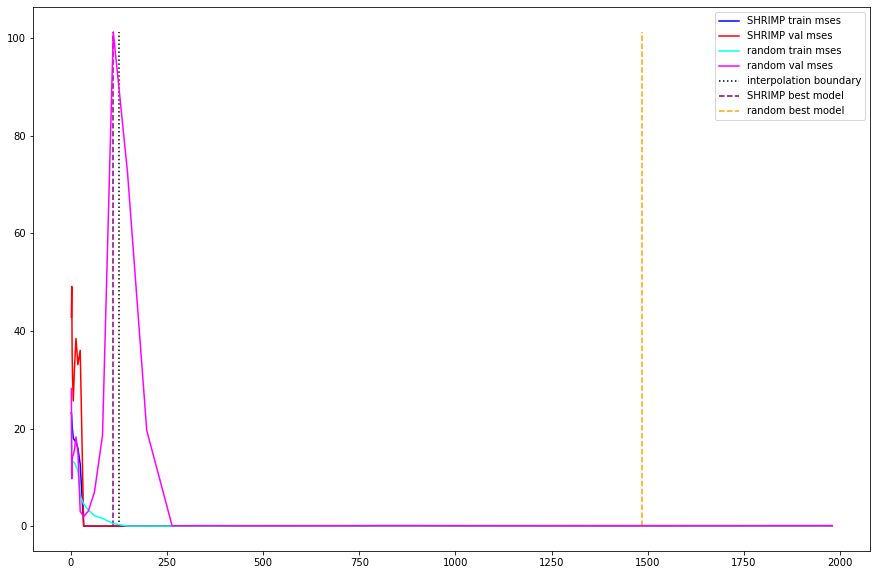

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(lengths, train_mses[q], label="SHRIMP train mses", color="blue")
plt.plot(lengths, val_mses[q], label="SHRIMP val mses", color="red")
plt.plot(lengths, train_mses_r[q], label="random train mses", color="cyan")
plt.plot(lengths, val_mses_r[q], label="random val mses", color="magenta")
plt.vlines(m*0.7*0.9, 0, max(max(train_mses[q]), max(val_mses[q]), max(train_mses_r[q]), max(val_mses_r[q])), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(best_model.n_best, 0, max(max(train_mses[q]), max(val_mses[q]), max(train_mses_r[q]), max(val_mses_r[q])), linestyles="dashed", colors="purple", label="SHRIMP best model")
plt.vlines(best_model_r.n_best, 0, max(max(train_mses[q]), max(val_mses[q]), max(train_mses_r[q]), max(val_mses_r[q])), linestyles="dashed", colors="orange", label="random best model")
plt.legend(loc="best")
plt.show()

In [69]:
growth = range(0, 1000, 1)
g_train_mses = []
g_val_mses = []
best_W = -1
best_val = np.inf
best_c = -1
Xtr1 = Xtr[:int(m*0.7*0.9), :]
Xval = Xtr[int(m*0.7*0.9):, :]
Ytr1 = Ytr[:int(m*0.7*0.9)]
Yval = Ytr[int(m*0.7*0.9):]
for g in growth:
    W, inds_track = make_W(d, q, N=g, scale=1/np.sqrt(q), sample=False)
    Atr1 = make_A(Xtr1, W)
    Aval = make_A(Xval, W)
    cg = l2(Atr1, Ytr1)
    val = np.sum(Yval-Aval@cg)**2/len(Yval)
    g_train_mses.append(np.sum(Ytr1-Atr1@cg)**2/len(Ytr1))
    g_val_mses.append(val)
    if val < best_val:
        best_val = val
        best_W = W
        best_c = cg

In [70]:
Ate = make_A(Xte, best_W)
err_g = np.sum(Yte-Ate@best_c)**2/len(Yte)
print("Err from growth: {}".format(err_g))

Err from growth: 0.14060238751086387


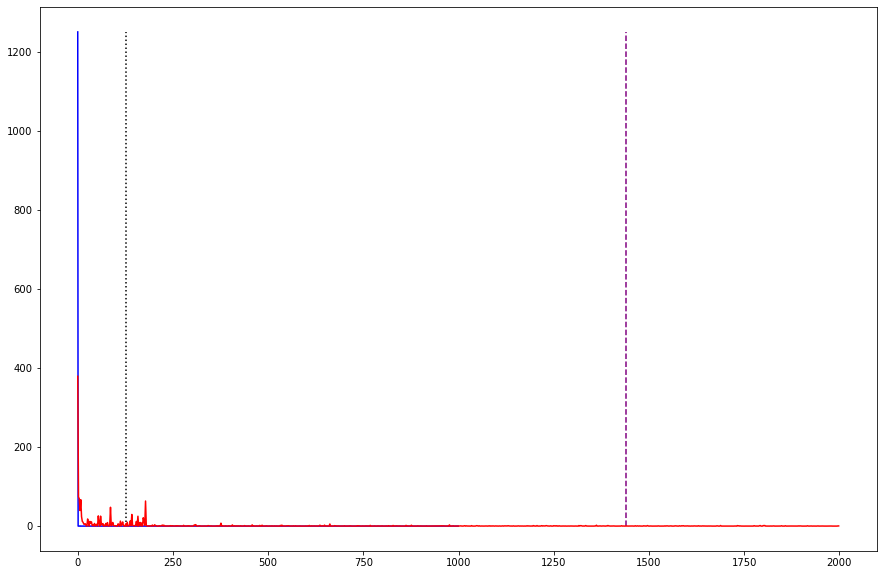

In [71]:
plt.figure(figsize=(15, 10))
plt.plot(growth, g_train_mses, label="Growth train mses", color="blue")
plt.plot([g*2 for g in growth], g_val_mses, label="Growth val mses", color="red")
plt.vlines(m*0.7*0.9, 0, max(max(g_train_mses), max(g_val_mses)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(len(best_c), 0, max(max(g_train_mses), max(g_val_mses)), linestyles="dashed", colors="purple", label="best model")
plt.show()

## $q=d$ (regular KRR)

In [75]:
Xtr, Xte, Ytr, Yte = getDataset(fn, d=d, m=m)
best_model, train_mses, val_mses, lengths = shrimp(Xtr, Ytr, orderCands=[d], verbose=0, N=N)
w_shrimp = np.zeros(2*best_model.W.shape[0])
w_shrimp[best_model.id_list] = best_model.w
Atr = make_A(Xtr, best_model.W)
w_l2 = l2(Atr, Ytr)
Ate = make_A(Xte, best_model.W)
err_shrimp = np.sum((Yte-Ate@w_shrimp)**2)/len(Yte)
err_l2 = np.sum((Yte-Ate@w_l2)**2)/len(Yte)
best_model_r, train_mses_r, val_mses_r, _ = shrimp(Xtr, Ytr, orderCands=[d], verbose=0, N=N, random=True)
w_r = np.zeros(2*best_model_r.W.shape[0])
w_r[best_model_r.id_list] = best_model_r.w
Ate = make_A(Xte, best_model_r.W)
err_r = np.sum((Yte-Ate@w_r)**2)/len(Yte)
print("Min l2: {}".format(err_l2))
print("SHRIMP: {}".format(err_shrimp))
print("Random pruning: {}".format(err_r))

Min l2: 0.2022518103130216
SHRIMP: 0.30887882439874254
Random pruning: 0.20916473672523894


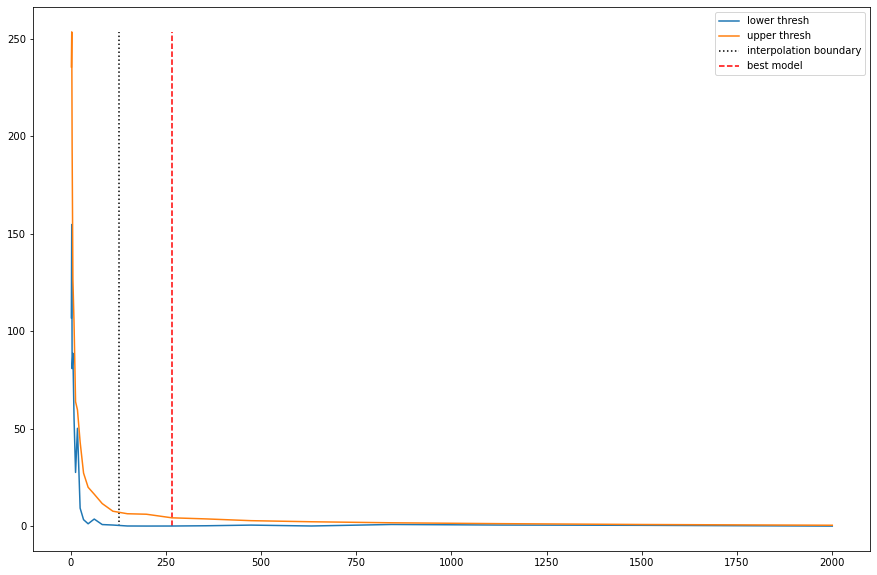

In [76]:
thresh = list(zip(*list(best_model.thresh.values())))
plt.figure(figsize=(15, 10))
plt.plot(lengths[:-1], thresh[0], label="lower thresh")
plt.plot(lengths[:-1], thresh[1], label="upper thresh")
plt.vlines(m*0.7*0.9, 0, max(max(thresh[0]), max(thresh[1])), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(best_model.n_best, 0, max(max(thresh[0]), max(thresh[1])), linestyles="dashed", colors="red", label="best model")
plt.legend(loc="best")
plt.show()

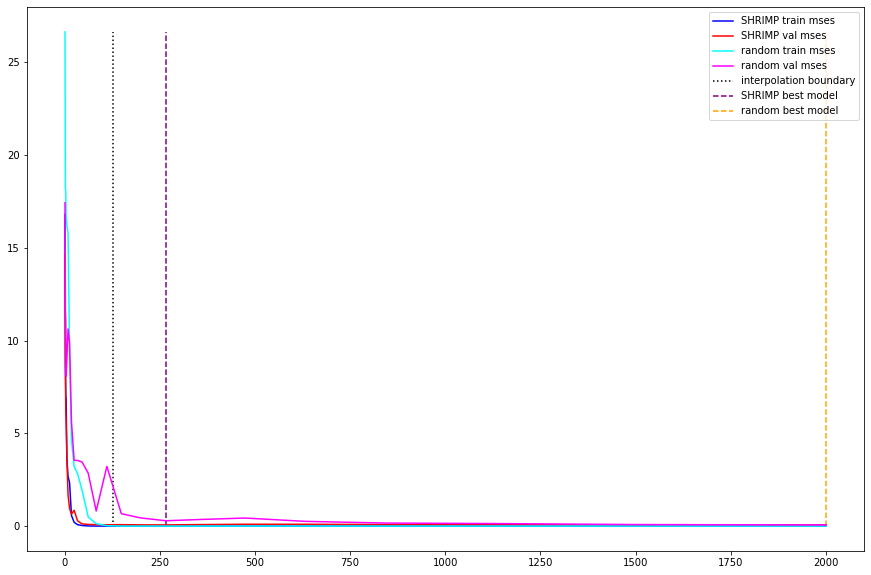

In [78]:
plt.figure(figsize=(15, 10))
plt.plot(lengths, train_mses[d], label="SHRIMP train mses", color="blue")
plt.plot(lengths, val_mses[d], label="SHRIMP val mses", color="red")
plt.plot(lengths, train_mses_r[d], label="random train mses", color="cyan")
plt.plot(lengths, val_mses_r[d], label="random val mses", color="magenta")
plt.vlines(m*0.7*0.9, 0, max(max(train_mses[d]), max(val_mses[d]), max(train_mses_r[d]), max(val_mses_r[d])), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(best_model.n_best, 0, max(max(train_mses[d]), max(val_mses[d]), max(train_mses_r[d]), max(val_mses_r[d])), linestyles="dashed", colors="purple", label="SHRIMP best model")
plt.vlines(best_model_r.n_best, 0, max(max(train_mses[d]), max(val_mses[d]), max(train_mses_r[d]), max(val_mses_r[d])), linestyles="dashed", colors="orange", label="random best model")
plt.legend(loc="best")
plt.show()

In [72]:
g_train_mses = []
g_val_mses = []
best_W = -1
best_val = np.inf
best_c = -1
Xtr1 = Xtr[:int(m*0.7*0.9), :]
Xval = Xtr[int(m*0.7*0.9):, :]
Ytr1 = Ytr[:int(m*0.7*0.9)]
Yval = Ytr[int(m*0.7*0.9):]
for g in growth:
    W, inds_track = make_W(d, d, N=g, scale=1/np.sqrt(d), sample=False)
    Atr1 = make_A(Xtr1, W)
    Aval = make_A(Xval, W)
    cg = l2(Atr1, Ytr1)
    val = np.sum(Yval-Aval@cg)**2/len(Yval)
    g_train_mses.append(np.sum(Ytr1-Atr1@cg)**2/len(Ytr1))
    g_val_mses.append(val)
    if val < best_val:
        best_val = val
        best_W = W
        best_c = cg

In [73]:
Ate = make_A(Xte, best_W)
err_g = np.sum(Yte-Ate@best_c)**2/len(Yte)
print("Err from growth: {}".format(err_g))

Err from growth: 0.8989922638961397


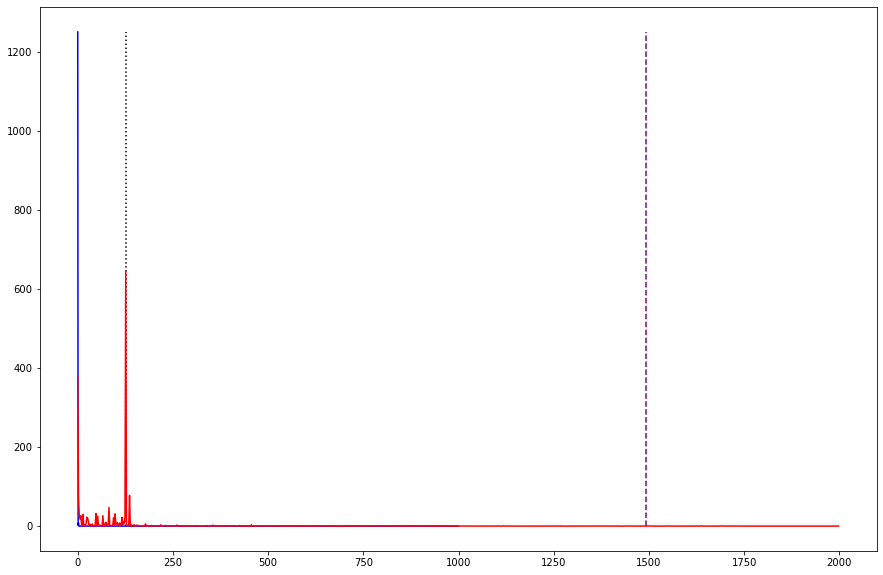

In [74]:
plt.figure(figsize=(15, 10))
plt.plot(growth, g_train_mses, label="Growth train mses", color="blue")
plt.plot([g*2 for g in growth], g_val_mses, label="Growth val mses", color="red")
plt.vlines(m*0.7*0.9, 0, max(max(g_train_mses), max(g_val_mses)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(len(best_c), 0, max(max(g_train_mses), max(g_val_mses)), linestyles="dashed", colors="purple", label="best model")
plt.show()